# NLPeasy Demo - OKCupid (2 / 2)
# Applied Machine Learning Days, Lausanne - 25 January 2020

In this part, we will try to use the enrichments generated in part 1 for more in-depth analysis of the data.

Let's see what knowledge we gain about the people from what they wrote.

First, let's again import some stuff we need to train a model:

In [1]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt

We have prepared the full enriched data set for you, you can load it now:

In [2]:
okc_enriched = pd.read_pickle('okc_enriched_demo')

In [3]:
pd.set_option('display.max_columns', None)
okc_enriched.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,height_cm,city,all_free_text,geolocation,sentiment_summary,sentiment_life,sentiment_goodat,sentiment_noticeabout,sentiment_favorites,sentiment_6things,sentiment_thinkingabout,sentiment_Fridaynight,sentiment_privatething,sentiment_messageme,all_free_text_entity_CARDINAL,all_free_text_entity_DATE,all_free_text_entity_EVENT,all_free_text_entity_FAC,all_free_text_entity_GPE,all_free_text_entity_LANGUAGE,all_free_text_entity_LAW,all_free_text_entity_LOC,all_free_text_entity_MONEY,all_free_text_entity_NORP,all_free_text_entity_ORDINAL,all_free_text_entity_ORG,all_free_text_entity_PERCENT,all_free_text_entity_PERSON,all_free_text_entity_PRODUCT,all_free_text_entity_QUANTITY,all_free_text_entity_TIME,all_free_text_entity_WORK_OF_ART,all_free_text_ents,all_free_text_num_ADJ,all_free_text_num_ADP,all_free_text_num_ADV,all_free_text_num_CCONJ,all_free_text_num_DET,all_free_text_num_INTJ,all_free_text_num_NOUN,all_free_text_num_NUM,all_free_text_num_PART,all_free_text_num_PRON,all_free_text_num_PROPN,all_free_text_num_PUNCT,all_free_text_num_SPACE,all_free_text_num_SYM,all_free_text_num_VERB,all_free_text_num_X,all_free_text_subj,all_free_text_vec,all_free_text_vec_normalized,all_free_text_verb,all_free_text_wc,essay0_entity_CARDINAL,essay0_entity_DATE,essay0_entity_FAC,essay0_entity_GPE,essay0_entity_LANGUAGE,essay0_entity_LOC,essay0_entity_MONEY,essay0_entity_NORP,essay0_entity_ORDINAL,essay0_entity_ORG,essay0_entity_PERCENT,essay0_entity_PERSON,essay0_entity_PRODUCT,essay0_entity_QUANTITY,essay0_entity_TIME,essay0_entity_WORK_OF_ART,essay0_ents,essay0_num_ADJ,essay0_num_ADP,essay0_num_ADV,essay0_num_CCONJ,essay0_num_DET,essay0_num_INTJ,essay0_num_NOUN,essay0_num_NUM,essay0_num_PART,essay0_num_PRON,essay0_num_PROPN,essay0_num_PUNCT,essay0_num_SPACE,essay0_num_SYM,essay0_num_VERB,essay0_num_X,essay0_subj,essay0_vec,essay0_vec_normalized,essay0_verb,essay0_wc,essay1_entity_CARDINAL,essay1_entity_DATE,essay1_entity_FAC,essay1_entity_GPE,essay1_entity_LANGUAGE,essay1_entity_LOC,essay1_entity_MONEY,essay1_entity_NORP,essay1_entity_ORDINAL,essay1_entity_ORG,essay1_entity_PERCENT,essay1_entity_PERSON,essay1_entity_PRODUCT,essay1_entity_QUANTITY,essay1_entity_TIME,essay1_entity_WORK_OF_ART,essay1_ents,essay1_num_ADJ,essay1_num_ADP,essay1_num_ADV,essay1_num_CCONJ,essay1_num_DET,essay1_num_INTJ,essay1_num_NOUN,essay1_num_NUM,essay1_num_PART,essay1_num_PRON,essay1_num_PROPN,essay1_num_PUNCT,essay1_num_SPACE,essay1_num_SYM,essay1_num_VERB,essay1_num_X,essay1_subj,essay1_vec,essay1_vec_normalized,essay1_verb,essay1_wc,essay2_entity_CARDINAL,essay2_entity_DATE,essay2_entity_GPE,essay2_entity_LANGUAGE,essay2_entity_LOC,essay2_entity_MONEY,essay2_entity_NORP,essay2_entity_ORDINAL,essay2_entity_ORG,essay2_entity_PERCENT,essay2_entity_PERSON,essay2_entity_QUANTITY,essay2_entity_TIME,essay2_ents,essay2_num_ADJ,essay2_num_ADP,essay2_num_ADV,essay2_num_CCONJ,essay2_num_DET,essay2_num_INTJ,essay2_num_NOUN,essay2_num_NUM,essay2_num_PART,essay2_num_PRON,essay2_num_PROPN,essay2_num_PUNCT,essay2_num_SPACE,essay2_num_SYM,essay2_num_VERB,essay2_num_X,essay2_subj,essay2_vec,essay2_vec_normalized,essay2_verb,essay2_wc,essay3_entity_CARDINAL,essay3_entity_DATE,essay3_entity_GPE,essay3_entity_LANGUAGE,essay3_entity_MONEY,essay3_entity_NORP,essay3_entity_ORDINAL,essay3_entity_ORG,essay3_entity_PERCENT,essay3_entity_PERSON,essay3_entity_PRODUCT,essay3_entity_QUANTITY,essay3_entity_TIME,essay3_ents,essay3_num_ADJ,essay3_num_ADP,essay3_num_ADV,essay3_num_CCONJ,essay3_num_DET,essay3_num_INTJ,essay3_num_NOUN,essay3_num_NUM,essay3_num_PART,essay3_num_PRON,essay3_num_PROPN,essay3_num_PUNCT,essay3_num_SPACE,essay3_num_SYM,essay3_num_VERB,essay3_num_X,essay3_subj,essay3_vec,essay3_vec_normalized,essay3_verb,essay3_wc,essay4_entity_CARDINAL,essay4_entity_

You may choose your own example of what you would like to find out with this dataset.

Our goal is to find out whether we can predict university graduates.

## Can we predict university graduates from the OK cupid dataset?

Let's try to construct a binary feature 'university_graduate' 0/1 from the education column.
What options do we have?

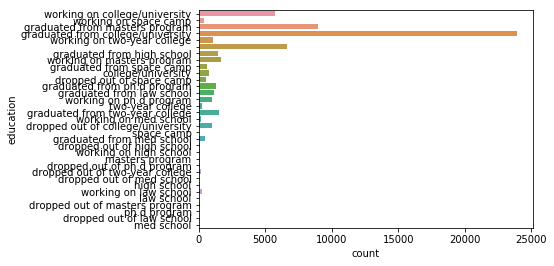

In [4]:
ax = sns.countplot(y='education', data= okc_enriched)

In [5]:
okc_enriched['education'].unique()

array(['working on college/university', 'working on space camp',
       'graduated from masters program',
       'graduated from college/university', 'working on two-year college',
       '', 'graduated from high school', 'working on masters program',
       'graduated from space camp', 'college/university',
       'dropped out of space camp', 'graduated from ph.d program',
       'graduated from law school', 'working on ph.d program',
       'two-year college', 'graduated from two-year college',
       'working on med school', 'dropped out of college/university',
       'space camp', 'graduated from med school',
       'dropped out of high school', 'working on high school',
       'masters program', 'dropped out of ph.d program',
       'dropped out of two-year college', 'dropped out of med school',
       'high school', 'working on law school', 'law school',
       'dropped out of masters program', 'ph.d program',
       'dropped out of law school', 'med school'], dtype=object)

We will use some categories of the education column as indicative for university_graduate = true

In [6]:
okc_enriched['university_graduate'] = 0
okc_enriched.loc[okc_enriched['education'] == 'graduated from college/university'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from masters program'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from ph.d program'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from law school'
             ,'university_graduate'] = 1
okc_enriched.loc[okc_enriched['education'] == 'graduated from med school'
             ,'university_graduate'] = 1

Let's see how balanced this is:

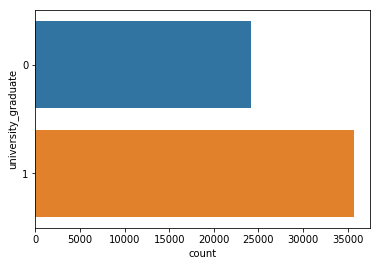

In [7]:
ax = sns.countplot(y='university_graduate', data= okc_enriched)

## Build Predictor variables
Let's see which predictors we want to use. We will do two round of prediction:
1. Analyse with simple text features like count of words, count of adjectives, along with some ohter attributes the users have provided (age, languages they speak...)
2. Include the word vector of all text they have written - can this add to prediction power?

First let's construct a column that indicates how many languages the user speaks, according to his own indication in 'languages':

In [10]:
# split language column
okc_enriched[['language0','language1','language2','language3','language4']] = okc_enriched['speaks'].str.split(pat=',',expand=True)
okc_enriched['count_languages'] = (okc_enriched[['language0', 'language1', 'language2','language3','language4']].notnull()).astype(int).sum(axis=1)

Let's define all predictors we want to use for (1):

In [13]:
col_features_without_vec = ['all_free_text_num_ADJ', 'all_free_text_num_ADP',
                            'all_free_text_num_ADV', 'all_free_text_num_CCONJ',
                            'all_free_text_num_DET',
                            'all_free_text_num_NOUN',
                            'all_free_text_num_PART', 'all_free_text_num_PRON',
                            'all_free_text_num_PUNCT',
                            'all_free_text_num_SPACE',
                            'all_free_text_num_VERB',
                            'all_free_text_wc', 'age', 'count_languages']

Let's also transform the word vector of 'all_free_text' to features:

In [14]:
df_text_vec = pd.DataFrame(okc_enriched['all_free_text_vec'].values.tolist())

In [15]:
df_text_vec.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.034343,0.160344,-0.171943,-0.063582,0.080312,0.034562,-0.001294,-0.121440,-0.007476,2.018822,-0.236109,0.077270,0.086609,-0.054293,-0.126250,-0.051836,-0.090125,1.065688,-0.184992,-0.000737,0.012388,-0.022864,-0.035853,-0.038700,-0.011080,0.047747,-0.052676,-0.064988,0.110792,-0.104201,-0.026954,0.074935,-0.086156,0.069592,0.097489,-0.079941,0.041403,0.040652,-0.060861,-0.043486,-0.029708,0.052965,-0.021349,-0.084216,0.041622,0.062697,-0.140258,0.007907,0.032986,0.005045,-0.039100,0.034381,0.012639,-0.044250,0.051062,0.034165,-0.048224,-0.064407,0.013651,-0.053258,-0.030864,-0.063993,-0.042945,0.184851,0.031985,-0.124501,-0.005935,0.081111,0.017874,0.128892,-0.003918,0.054587,0.170187,-0.030975,0.100930,0.056429,0.077137,-0.052941,-0.052542,0.197387,-0.040192,0.059570,-0.094838,-0.029327,0.012423,-0.201039,0.112827,-0.079810,0.269801,0.030641,-0.103015,-0.018653,-0.075423,0.040494,0.081926,-0.016951,-0.005776,-0.056065,-0.044191,-0.048109,-0.015596,0.028009,-0.080584,-0.055051,0.114433,-0.608942,0.112910,-0.018211,0.027263,0.015144,0.092765,-0.172429,0.098518,-0.121866,-0.006997,-0.019191,0.025614,-0.025972,-0.004612,-0.032936,0.089796,-0.052303,0.001399,-0.005044,0.054501,0.084066,-0.029864,-0.083642,0.045668,-0.011423,-0.015992,-0.052563,-0.136214,0.055783,0.033787,0.034792,-0.013322,-0.014865,-0.027887,-0.016523,-1.388018,0.093127,0.099348,0.000633,-0.039125,-0.006222,-0.069125,0.016174,0.014110,-0.076377,0.014616,0.027516,0.071078,0.010705,-0.071318,-0.002517,-0.019425,-0.060561,0.005000,-0.071923,-0.010295,0.005612,-0.044022,-0.029540,-0.033528,-0.141470,0.075353,-0.054523,0.098028,0.021423,-0.025468,-0.013077,0.109798,-0.101276,-0.041605,0.041092,-0.035609,-0.029362,0.024990,-0.073023,0.000246,-0.077568,-0.117713,-0.086078,-0.002732,-0.019835,-0.048404,-0.042958,0.077006,0.034919,-0.010144,0.007951,-0.049459,-0.027164,0.024824,0.104107,-0.011028,-0.113896,0.016915,0.157756,-0.010502,-0.071629,-0.073660,-0.034489,0.147878,0.026186,0.061005,0.014020,0.045662,0.008942,-0.098917,-0.081609,-0.046411,-0.160859,0.063496,0.148450,-0.047968,0.031923,-0.184478,0.035737,0.047727,0.007406,-0.028725,0.043385,-0.008538,-0.048149,-0.009557,0.103972,-0.016999,-0.010779,-0.125771,0.020926,0.056680,0.109959,-0.073693,-0.084585,-0.025179,-0.053094,-0.039149,0.114191,0.053849,0.024955,0.001487,0.069713,0.107366,-0.136745,-0.107887,-0.092087,-0.138370,0.146359,0.043741,-0.052971,-0.085767,0.014263,0.043141,0.166356,0.100186,-0.092788,-0.059473,0.039543,0.045092,0.168402,0.048067,0.069118,0.070376,-0.088863,-0.032557,0.072452,0.298977,0.040190,-0.004633,-0.021994,-0.079842,-0.120889,-0.113094,-0.001075,0.018839,0.048221,0.014519,0.170756,0.169603,-0.003230,0.038217,-0.072009,-0.058308,-0.061244,0.123537,-0.105241,0.118664,-0.031168,-0.148355,0.017223,-0.056840,-0.027247,0.001005,0.022845,-0.010594,-0.048526,-0.023117,0.084808
1,-0.047867,0.197074,-0.169698,-0.100385,0

Combine all features we generated in one df:

In [16]:
df_without_vec = okc_enriched[col_features_without_vec]
all_features_df = df_without_vec.merge(df_text_vec, left_index = True, right_index= True)

See where we have missing values:

In [17]:
all_features_df.isna().sum()

all_free_text_num_ADJ      2631
all_free_text_num_ADP      2928
all_free_text_num_ADV      3417
all_free_text_num_CCONJ    3496
all_free_text_num_DET      3139
all_free_text_num_NOUN     2343
all_free_text_num_PART     4228
all_free_text_num_PRON     3013
all_free_text_num_PUNCT    2617
all_free_text_num_SPACE       0
all_free_text_num_VERB     2377
all_free_text_wc              0
age                           0
count_languages               0
0                             0
1                             0
2                             0
3                             0
4                             0
5                             0
6                             0
7                             0
8                             0
9                             0
10                            0
11                            0
12                            0
13                            0
14                            0
15                            0
                           ... 
270     

In [18]:
all_features_df.shape

(59946, 314)

... and drop them:

In [20]:
all_features_df = all_features_df.dropna()

In [21]:
all_features_df.shape

(54321, 314)

Build the target vec:

In [22]:
okc_target = okc_enriched[okc_enriched.index.isin(all_features_df.index)]
target = np.array(okc_target['university_graduate'])

In [23]:
len(target)

54321

### 1. Predict with non-vec features only
This is the set of features we want to include:

In [24]:
features_without_vec = all_features_df[col_features_without_vec]

### Train / Test

In [25]:
train_features_without_vec, test_features_without_vec, train_target_without_vec, test_target_without_vec = train_test_split(features_without_vec, target, test_size=0.25, random_state = 42)

In [26]:
train_features_without_vec.shape

(40740, 14)

In [27]:
test_features_without_vec.shape

(13581, 14)

### Predict and fit

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 2)
pprint(rf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}


In [29]:
rf.fit(train_features_without_vec, train_target_without_vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [30]:
predictions_without_vec = rf.predict(test_features_without_vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [33]:
print("Accuracy, Random Forest: ", metrics.accuracy_score(test_target_without_vec, predictions_without_vec))
print("AUC Score, Random Forest: ", metrics.roc_auc_score(test_target_without_vec, predictions_without_vec))
print(metrics.classification_report(test_target_without_vec, predictions_without_vec))

Accuracy, Random Forest:  0.6830130329136294
AUC Score, Random Forest:  0.6234857476421543
              precision    recall  f1-score   support

           0       0.67      0.36      0.47      5266
           1       0.69      0.89      0.77      8315

   micro avg       0.68      0.68      0.68     13581
   macro avg       0.68      0.62      0.62     13581
weighted avg       0.68      0.68      0.66     13581



Function to plot confusion matrix

In [34]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    #compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    #we want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # and label them with respective list entries
           xticklabels=classes, yticklabels=classes, 
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    #Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', 
            rotation_mode = 'anchor')
    
    #Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2. 
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, (i+0.4)*0.6, format(cm[i, j], fmt),
                    ha='center', va='center', 
                    color='white' if cm[i,j] > thresh else 'black')
    
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Function for ROC curve:

In [35]:
def plot_roc_curve(test_predictions, test_target):
    rf_roc_auc = metrics.roc_auc_score(y_score = test_predictions, y_true = test_target)
    fpr, tpr, thresholds = metrics.roc_curve(test_target, test_predictions)
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)'% rf_roc_auc)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

Confusion matrix, without normalization
[[1887 3379]
 [ 926 7389]]
Normalized confusion matrix
[[0.36 0.64]
 [0.11 0.89]]


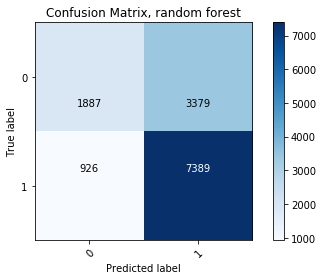

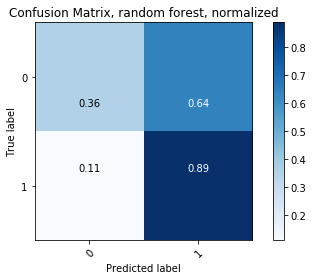

In [36]:
plot_confusion_matrix(test_target_without_vec, predictions_without_vec, classes = np.array([0,1]),
                      title="Confusion Matrix, random forest")
plot_confusion_matrix(test_target_without_vec, predictions_without_vec, classes = np.array([0,1]), normalize=True,
                      title="Confusion Matrix, random forest, normalized")

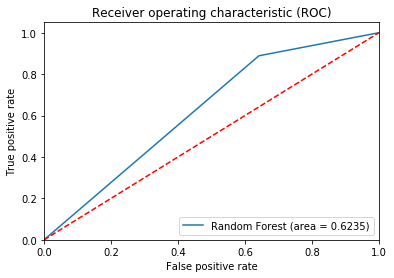

In [37]:
plot_roc_curve(predictions_without_vec, test_target_without_vec)

In [40]:
prob_predictions_without_vec = rf.predict_proba(test_features_without_vec)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


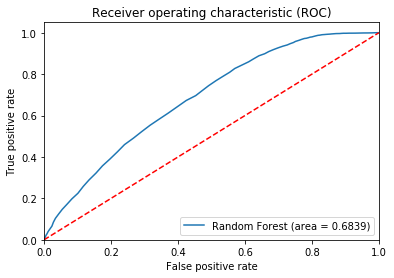

In [41]:
plot_roc_curve(prob_predictions_without_vec, test_target_without_vec)

Function to plot importances:

In [42]:
def plot_importance_top(rf, features, top_n=30):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    x = np.arange(len(features.columns))
    y = importances[indices]
    x_labels = features.columns[indices]
    
    plt.figure()
    plt.bar(x[0:top_n], y[0:top_n], tick_label = x_labels[0:top_n])
    plt.xticks(rotation=90)


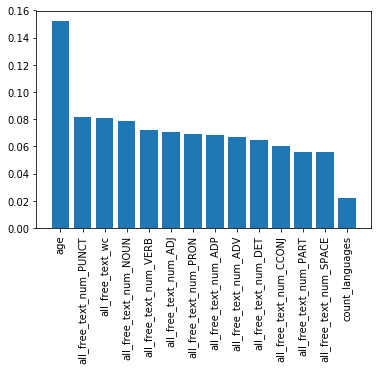

In [43]:
plot_importance_top(rf, features_without_vec)

### 2. Predict with all features, including vec
i.e., now we use all_features_df

In [44]:
train_predictors, test_predictors, train_target, test_target = train_test_split(all_features_df, target, test_size=0.25, random_state = 42)

In [45]:
rf2 = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 2)
rf2.fit(train_predictors, train_target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

Predict and see result:

In [46]:
predictions = rf2.predict(test_predictors)
print("Accuracy, Random Forest: ", metrics.accuracy_score(test_target, predictions))
print("AUC Score, Random Forest: ", metrics.roc_auc_score(test_target, predictions))
print(metrics.classification_report(test_target, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy, Random Forest:  0.6956041528606141
AUC Score, Random Forest:  0.6452577935034745
              precision    recall  f1-score   support

           0       0.67      0.42      0.52      5266
           1       0.70      0.87      0.78      8315

   micro avg       0.70      0.70      0.70     13581
   macro avg       0.69      0.65      0.65     13581
weighted avg       0.69      0.70      0.68     13581



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


Confusion matrix, without normalization
[[2217 3049]
 [1085 7230]]
Normalized confusion matrix
[[0.42 0.58]
 [0.13 0.87]]


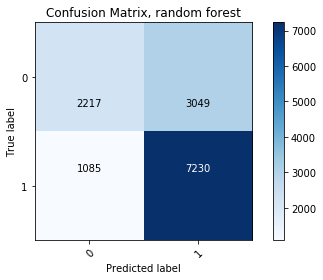

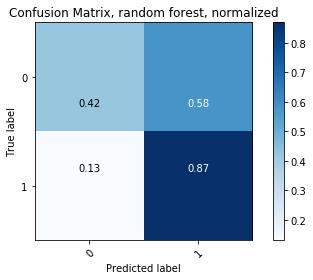

In [47]:
plot_confusion_matrix(test_target, predictions, classes = np.array([0,1]),
                      title="Confusion Matrix, random forest")
plot_confusion_matrix(test_target, predictions, classes = np.array([0,1]), normalize=True,
                      title="Confusion Matrix, random forest, normalized")

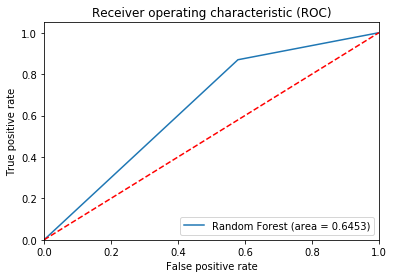

In [48]:
plot_roc_curve(predictions, test_target)

In [49]:
prob_predictions = rf2.predict_proba(test_predictors)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


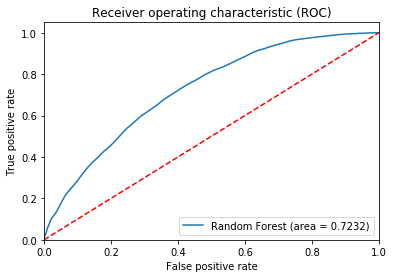

In [50]:
plot_roc_curve(prob_predictions, test_target)

In [ ]:
plot_importance_top(rf2, all_features_df)